# Exploring Air Quality Data

Exploring some air quality data, and methods for cutting it to shapefiles of principal urban areas (PUAs).

## Setup

In [2]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd

import os
import sys
import glob

import shape_utils as shape

### Load Data

In [3]:
folder = '/data/covid19-response-blob/data_nc_daily/'
filepaths = {path: glob.glob(os.path.join(folder, path, '*.nc')) for path in os.listdir(folder)}
params = list(filepaths.keys())

print(params)
print(len(filepaths[params[0]]))

['sh_max', 'sh_mean', 'sh_min', 'sw_max', 'sw_mean', 't1o5m_max', 't1o5m_mean', 't1o5m_min']
91


In [27]:
%%time
cubes = iris.cube.CubeList([])

for param in params:
    cubes.extend(iris.load(filepaths[param]))
    
print(cubes)

0: specific_humidity / (1)             (time: 91; latitude: 1920; longitude: 2560)
1: specific_humidity / (1)             (time: 91; latitude: 1920; longitude: 2560)
2: specific_humidity / (1)             (time: 91; latitude: 1920; longitude: 2560)
3: m01s01i202 / (1)                    (time: 91; latitude: 1920; longitude: 2560)
4: m01s01i202 / (1)                    (time: 91; latitude: 1920; longitude: 2560)
5: air_temperature / (K)               (time: 91; latitude: 1920; longitude: 2560)
6: air_temperature / (K)               (time: 91; latitude: 1920; longitude: 2560)
7: air_temperature / (K)               (time: 91; latitude: 1920; longitude: 2560)
CPU times: user 57.8 s, sys: 3.12 s, total: 1min
Wall time: 5min 16s


In [28]:
uk_cubes = iris.cube.CubeList([cube.intersection(latitude=(48, 63), longitude=(-15, 5)) for cube in cubes])
print(uk_cubes)

0: specific_humidity / (1)             (time: 91; latitude: 160; longitude: 143)
1: specific_humidity / (1)             (time: 91; latitude: 160; longitude: 143)
2: specific_humidity / (1)             (time: 91; latitude: 160; longitude: 143)
3: m01s01i202 / (1)                    (time: 91; latitude: 160; longitude: 143)
4: m01s01i202 / (1)                    (time: 91; latitude: 160; longitude: 143)
5: air_temperature / (K)               (time: 91; latitude: 160; longitude: 143)
6: air_temperature / (K)               (time: 91; latitude: 160; longitude: 143)
7: air_temperature / (K)               (time: 91; latitude: 160; longitude: 143)


In [29]:
CRS = uk_cubes[0].coord_system()
CRS

GeogCS(6371229.0)

In [5]:
cube = iris.load_cube('/data/covid19-ancillary-data/data_nc_daily/t1o5m_max/t1o5m_max_20200103.nc')
cube

<iris 'Cube' of air_temperature / (K) (latitude: 1920; longitude: 2560)>

In [6]:
cells = [cell for cell in cube.coord('time').cells()]
cells[0]

Cell(point=cftime.DatetimeGregorian(2020-01-03 11:30:00), bound=(cftime.DatetimeGregorian(2020-01-03 00:00:00), cftime.DatetimeGregorian(2020-01-03 23:00:00)))

### Load shapefile

In [3]:
regions_shp = '/data/covid19-response-blob/shapefiles/UK/UK_covid_reporting_regions.shp'
regions_reader = shpreader.Reader(regions_shp)

In [4]:
region_names = [record.attributes['name'] for record in regions_reader.records()]

print(region_names)

['Hartlepool', 'Middlesbrough', 'Redcar and Cleveland', 'Stockton-on-Tees', 'Darlington', 'Halton', 'Warrington', 'Blackburn with Darwen', 'Blackpool', 'Kingston upon Hull, City of', 'East Riding of Yorkshire', 'North East Lincolnshire', 'North Lincolnshire', 'York', 'Derby', 'Leicester', 'Rutland', 'Nottingham', 'Herefordshire, County of', 'Telford and Wrekin', 'Stoke-on-Trent', 'Bath and North East Somerset', 'Bristol, City of', 'North Somerset', 'South Gloucestershire', 'Plymouth', 'Torbay', 'Swindon', 'Peterborough', 'Luton', 'Southend-on-Sea', 'Thurrock', 'Medway', 'Bracknell Forest', 'West Berkshire', 'Reading', 'Slough', 'Windsor and Maidenhead', 'Wokingham', 'Milton Keynes', 'Brighton and Hove', 'Portsmouth', 'Southampton', 'Isle of Wight', 'County Durham', 'Cheshire East', 'Cheshire West and Chester', 'Shropshire', 'Cornwall', 'Isles of Scilly', 'Wiltshire', 'Bedford', 'Trafford', 'Central Bedfordshire', 'Northumberland', 'Bournemouth, Christchurch and Poole', 'Dorset', 'Bolto

In [5]:
def get_region_record(shapefile, target, attribute='name'):
    '''
    Get the geometries for the specified location.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = 'Could not find region with name "{}".'
        raise ValueError(emsg.format(target))
    return result

In [6]:
region_record = get_region_record(regions_reader, 'Manchester')
region_record

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x7f6b4400bb00>, {'code': 'E08000003', 'name': 'Manchester', 'area': 111895372.049991}, <fields>>

## Work out which files have been written, and which still have to be

In [41]:
csvs = glob.glob('/data/misc/covid-19/regional_data/*.csv')

In [42]:
df = dd.read_csv(csvs)
df.compute()

,region,date,specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K)
0,Hampshire,2020-01-01,0.006390,0.005631,0.005040,147.596450,23.381704,281.01580,279.54037,277.95755
1,Hampshire,2020-01-02,0.007195,0.006580,0.006082,97.277590,15.140271,283.15085,281.94280,280.36322
2,Hampshire,2020-01-03,0.007592,0.005721,0.004235,194.037430,31.136189,283.74826,280.91147,277.04803
3,Hampshire,2020-01-04,0.005666,0.005046,0.004283,117.046104,18.044327,280.91030,278.72880,276.05670
4,Hampshire,2020-01-05,0.005917,0.005553,0.005100,139.915510,22.792992,281.66705,280.22424,279.15433
...,...,...,...,...,...,...,...,...,...,...
86,Warwickshire,2020-03-27,0.004211,0.003734,0.003337,565.088560,165.535190,284.58790,278.38306,273.25650
87,Warwickshire,2020-03-28,0.004639,0.003956,0.003408,511.124020,132.670270,283.10287,278.83084,275.48960
88,Warwickshire,2020-03-29,0.003657,0.002885,0.002218,472.583340,124.257965,280.05045,277.27072,275.08755
89,Warwickshire,2020-03-30,0.005152,0.004088,0.002960,352.203770,83.053750,280.93393,277.59485,273.22070


In [43]:
written = list(df['region'].unique().compute())
written

['Hampshire',
 'St. Helens',
 'Thurrock',
 'Swindon',
 'Windsor and Maidenhead',
 'Leicestershire',
 'Bournemouth, Christchurch and Poole',
 'Havering',
 'Wolverhampton',
 'Bedford',
 'Southend-on-Sea',
 'North Somerset',
 'Doncaster',
 'Wokingham',
 'West Sussex',
 'Nottinghamshire',
 'Belfast',
 'Shropshire',
 'Luton',
 'Orkney',
 'Cheshire East',
 'Leeds',
 'York',
 'Bury',
 'Wirral',
 'Portsmouth',
 'North Tyneside',
 'Waltham Forest',
 'Dudley',
 'Devon',
 'Western Isles',
 'Stockton-on-Tees',
 'County Durham',
 'Herefordshire, County of',
 'Blackpool',
 'Brighton and Hove',
 'Liverpool',
 'Solihull',
 'Walsall',
 'Wandsworth',
 'Northumberland',
 'Trafford',
 'Hartlepool',
 'Shetland',
 'Oldham',
 'Highland',
 'Camden',
 'Stoke-on-Trent',
 'Bristol, City of',
 'Betsi Cadwaladr University Health Board',
 'North Lincolnshire',
 'Gateshead',
 'Middlesbrough',
 'Bradford',
 'Hounslow',
 'Tameside',
 'West Berkshire',
 'Halton',
 'Blackburn with Darwen',
 'Southwark',
 'Mid Ulster',
 

In [44]:
len(written)

181

In [45]:
unwritten = list(set(region_names).difference(set(written)))
len(unwritten)

2

In [47]:
unwritten

['City of London', 'Kensington and Chelsea']

In [46]:
len(unwritten)+len(written)

183

## Create a pipeline

In [22]:
def parse_data_name(cube):
    name = cube.name()
    method = cube.cell_methods[0].method.replace('imum', '')
    units = cube.units
    
    if name == 'm01s01i202':
        name = 'short_wave_radiation'
        units = 'W/m2'
    
    return f'{name}_{method} ({units})'

In [23]:
def extract(location):
    region = get_region_record(regions_reader, location)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(uk_cubes)
#     cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    return cut_cubes

In [36]:
def extract_save(location):
    region = get_region_record(regions_reader, location)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(uk_cubes)
    cubes_col = {cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes}
    time = cubes_col[0].coord('time')
    data = {'region_name': [location]*len(time.points),
            'date': [cell.point.date() for cell in time.cells()]}
    data.update({parse_data_name(cube): cube.data for cube in cubes_col})

    df = pd.DataFrame(data)
    print(f'  {location}: Success')
    return df

## Save dataframe to csv for each location

In [30]:
print(uk_cubes)

0: specific_humidity / (1)             (time: 91; latitude: 160; longitude: 143)
1: specific_humidity / (1)             (time: 91; latitude: 160; longitude: 143)
2: specific_humidity / (1)             (time: 91; latitude: 160; longitude: 143)
3: m01s01i202 / (1)                    (time: 91; latitude: 160; longitude: 143)
4: m01s01i202 / (1)                    (time: 91; latitude: 160; longitude: 143)
5: air_temperature / (K)               (time: 91; latitude: 160; longitude: 143)
6: air_temperature / (K)               (time: 91; latitude: 160; longitude: 143)
7: air_temperature / (K)               (time: 91; latitude: 160; longitude: 143)


In [31]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
%%time
dfs = []
for location in unwritten[17:]:
    try:
        df = extract_save(location)
        dfs.append(df)
        fname = location.replace(' ', '_').replace(',','').replace('.','')
        df.to_csv(f'/data/misc/covid-19/regional_data/{fname}_daily_met_data_2020jan-mar.csv', index=False)
        print(f'  {location}: Success')
        display(df.iloc[[0]])
    except Exception as e:
        print(f'x {location}: Error \n  x  {e}')

x Kensington and Chelsea: Error 
  x  Cannot collapse a dimension which does not describe any data.
  Lothian: Success
  Lothian: Success
  Cumbria: Success
  Cumbria: Success
  Derry City and Strabane: Success
  Derry City and Strabane: Success
  Cardiff and Vale University Health Board: Success
  Cardiff and Vale University Health Board: Success
  Lambeth: Success
  Lambeth: Success
  Brent: Success
  Brent: Success
  Tayside: Success
  Tayside: Success
  Somerset: Success
  Somerset: Success
  Fermanagh and Omagh: Success
  Fermanagh and Omagh: Success
  Gloucestershire: Success
  Gloucestershire: Success
  Haringey: Success
  Haringey: Success
  Lisburn and Castlereagh: Success
  Lisburn and Castlereagh: Success
  Enfield: Success
  Enfield: Success
  Staffordshire: Success
  Staffordshire: Success
  Causeway Coast and Glens: Success
  Causeway Coast and Glens: Success
  Ealing: Success
  Ealing: Success
  Lewisham: Success
  Lewisham: Success
  Islington: Success
  Islington: Succ

In [28]:
pd.concat(dfs)

,region,date,specific_humidity_max (1),specific_humidity_min (1),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_mean (W/m2),short_wave_radiation_max (W/m2),air_temperature_max (K),specific_humidity_mean (1)
0,Stockton-on-Tees,2020-01-01,0.004910,0.004367,276.770996,275.552094,21.965782,148.239578,278.774292,0.004625
1,Stockton-on-Tees,2020-01-02,0.006592,0.004774,279.768219,277.203125,18.475187,115.786461,282.833344,0.005493
2,Stockton-on-Tees,2020-01-03,0.006727,0.004069,279.290009,277.343750,21.559532,149.520828,282.779510,0.004840
3,Stockton-on-Tees,2020-01-04,0.005371,0.004639,279.690247,278.453125,23.735315,152.190979,281.750000,0.005005
4,Stockton-on-Tees,2020-01-05,0.006348,0.005371,281.245270,279.979156,16.400391,119.282990,282.498260,0.005747
...,...,...,...,...,...,...,...,...,...,...
86,Gateshead,2020-03-27,0.005310,0.003876,277.830017,274.171875,146.058441,522.933594,281.824219,0.004410
87,Gateshead,2020-03-28,0.005127,0.002686,278.365784,276.500000,84.216965,376.367188,280.449219,0.004064
88,Gateshead,2020-03-29,0.003387,0.002625,276.900543,275.605469,87.635742,318.162109,278.281250,0.002954
89,Gateshead,2020-03-30,0.004944,0.003448,279.487732,277.408203,121.871346,500.935547,282.322266,0.004155


In [29]:
8099/91

89.0

In [54]:
csvs = glob.glob('/data/misc/covid-19/regional_data/*.csv')
csvnames = [' '.join(file.split('/')[-1].split('_')[:-4]) for file in files]

csvnames

['Barnsley',
 'Bath and North East Somerset',
 'Bedford',
 'Birmingham',
 'Blackburn with Darwen',
 'Blackpool',
 'Bolton',
 'Bournemouth Christchurch and Poole',
 'Bracknell Forest',
 'Bradford',
 'Brighton and Hove',
 'Bristol City of',
 'Bury',
 'Calderdale',
 'Central Bedfordshire',
 'Cheshire East',
 'Cheshire West and Chester',
 'Cornwall',
 'County Durham',
 'Coventry',
 'Darlington',
 'Derby',
 'Doncaster',
 'Dorset',
 'Dudley',
 'East Riding of Yorkshire',
 'Gateshead',
 'Halton',
 'Hartlepool',
 'Herefordshire County of',
 'Isle of Wight',
 'Isles of Scilly',
 'Kingston upon Hull City of',
 'Kirklees',
 'Knowsley',
 'Leeds',
 'Leicester',
 'Liverpool',
 'Luton',
 'Manchester',
 'Medway',
 'Middlesbrough',
 'Milton Keynes',
 'Newcastle upon Tyne',
 'North East Lincolnshire',
 'North Lincolnshire',
 'North Somerset',
 'North Tyneside',
 'Northumberland',
 'Nottingham',
 'Oldham',
 'Peterborough',
 'Plymouth',
 'Portsmouth',
 'Reading',
 'Redcar and Cleveland',
 'Rochdale',
 'Ro

In [57]:
remaining = set(region_names).difference(set(csvnames))
remaining

{'Aneurin Bevan University Health Board',
 'Antrim and Newtownabbey',
 'Ards and North Down',
 'Armagh City, Banbridge and Craigavon',
 'Ayrshire and Arran',
 'Barking and Dagenham',
 'Barnet',
 'Belfast',
 'Betsi Cadwaladr University Health Board',
 'Bexley',
 'Borders',
 'Bournemouth, Christchurch and Poole',
 'Brent',
 'Bristol, City of',
 'Bromley',
 'Buckinghamshire',
 'Cambridgeshire',
 'Camden',
 'Cardiff and Vale University Health Board',
 'Causeway Coast and Glens',
 'City of London',
 'Croydon',
 'Cumbria',
 'Cwm Taf Morgannwg University Health Board',
 'Derbyshire',
 'Derry City and Strabane',
 'Devon',
 'Dumfries and Galloway',
 'Ealing',
 'East Sussex',
 'Enfield',
 'Essex',
 'Fermanagh and Omagh',
 'Fife',
 'Forth Valley',
 'Gloucestershire',
 'Grampian',
 'Greater Glasgow and Clyde',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Hampshire',
 'Haringey',
 'Harrow',
 'Havering',
 'Herefordshire, County of',
 'Hertfordshire',
 'Highland',
 'Hillingdon',
 'Hounslow'

In [58]:
print(len(region_names))
print(len(csvnames))
print(len(remaining))

183
92
95


In [61]:
92+95

187

In [ ]:
list(remainging)[0:2]

## Combine dataframes into one large one

In [19]:
csvs = glob.glob('/data/covid19-ancillary-data/regional_data/*.csv')
csvs.pop(csvs.index('/data/covid19-ancillary-data/regional_data/_UK_daily_met_data_2020jan-mar.csv'))
len(csvs)

181

In [20]:
%%time
dfd = dd.read_csv(csvs).compute().reset_index(drop=True)
dfd

CPU times: user 2.02 s, sys: 302 ms, total: 2.33 s
Wall time: 2.07 s


,region,date,specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K)
0,Aneurin Bevan University Health Board,2020-01-01,0.006246,0.005460,0.004842,107.931854,15.872722,280.32380,278.65225,277.146700
1,Aneurin Bevan University Health Board,2020-01-02,0.007256,0.006177,0.005154,80.705290,13.096335,282.86154,280.63858,278.073360
2,Aneurin Bevan University Health Board,2020-01-03,0.007141,0.005413,0.004333,161.631520,28.314524,282.58160,279.85855,276.901920
3,Aneurin Bevan University Health Board,2020-01-04,0.005690,0.005051,0.004306,98.807290,16.487267,280.16450,278.74075,276.348970
4,Aneurin Bevan University Health Board,2020-01-05,0.005961,0.005630,0.005310,95.183590,14.714047,280.77258,279.83930,279.097230
...,...,...,...,...,...,...,...,...,...,...
16466,York,2020-03-27,0.004395,0.003282,277.964000,272.956600,169.295930,544.65106,283.71700,0.003835
16467,York,2020-03-28,0.004883,0.003092,278.985050,276.449650,108.072990,464.07465,282.71180,0.004111
16468,York,2020-03-29,0.003418,0.002713,276.996100,274.286470,89.059105,357.05554,279.44965,0.003034
16469,York,2020-03-30,0.005046,0.003201,278.983000,275.425350,78.952770,335.86285,281.85416,0.004357


In [21]:
%%time
dfp = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
dfp

CPU times: user 548 ms, sys: 30.4 ms, total: 578 ms
Wall time: 606 ms


,region,date,specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K)
0,Aneurin Bevan University Health Board,2020-01-01,0.006246,0.005460,0.004842,107.931854,15.872722,280.32380,278.65225,277.14670
1,Aneurin Bevan University Health Board,2020-01-02,0.007256,0.006177,0.005154,80.705290,13.096335,282.86154,280.63858,278.07336
2,Aneurin Bevan University Health Board,2020-01-03,0.007141,0.005413,0.004333,161.631520,28.314524,282.58160,279.85855,276.90192
3,Aneurin Bevan University Health Board,2020-01-04,0.005690,0.005051,0.004306,98.807290,16.487267,280.16450,278.74075,276.34897
4,Aneurin Bevan University Health Board,2020-01-05,0.005961,0.005630,0.005310,95.183590,14.714047,280.77258,279.83930,279.09723
...,...,...,...,...,...,...,...,...,...,...
16466,York,2020-03-27,0.004395,0.003835,0.003282,544.651060,169.295930,283.71700,277.96400,272.95660
16467,York,2020-03-28,0.004883,0.004111,0.003092,464.074650,108.072990,282.71180,278.98505,276.44965
16468,York,2020-03-29,0.003418,0.003034,0.002713,357.055540,89.059105,279.44965,276.99610,274.28647
16469,York,2020-03-30,0.005046,0.004357,0.003201,335.862850,78.952770,281.85416,278.98300,275.42535


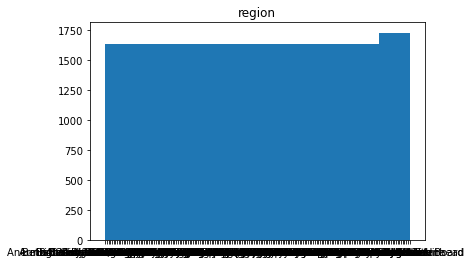

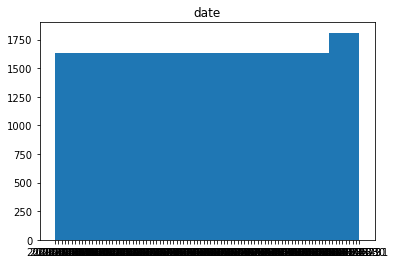

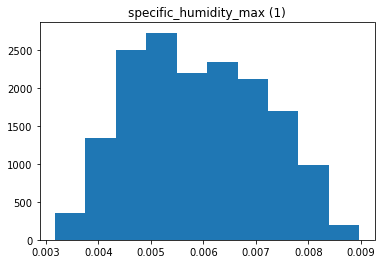

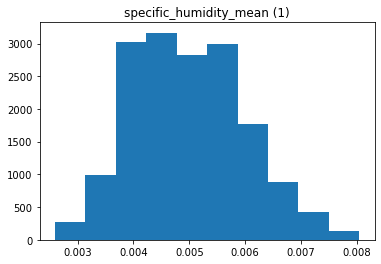

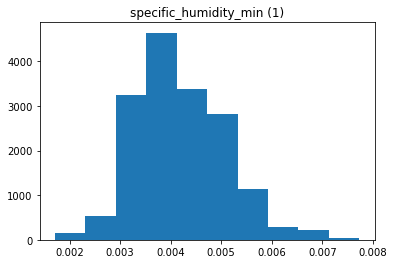

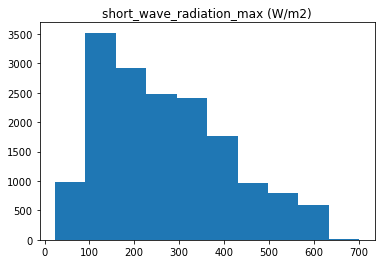

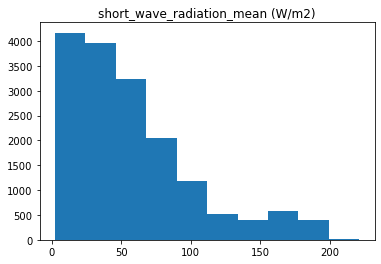

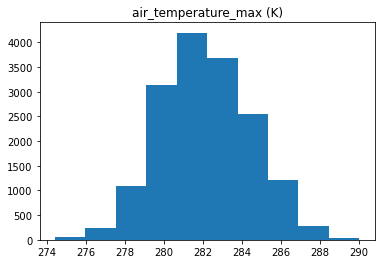

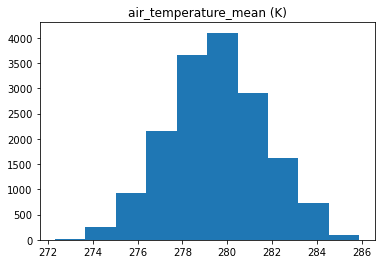

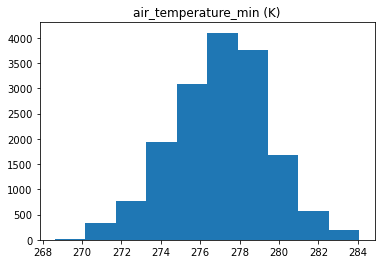

CPU times: user 4.51 s, sys: 362 ms, total: 4.88 s
Wall time: 4.79 s


In [26]:
%%time
for col in dfp:
    plt.hist(dfp[col])
    plt.title(f'{col}')
    plt.show()

In [27]:
%%time
fpath = './UKregions_daily_meteodata_2020jan-mar.csv'
dfp.to_csv(fpath, index=False)

CPU times: user 205 ms, sys: 15.9 ms, total: 220 ms
Wall time: 225 ms


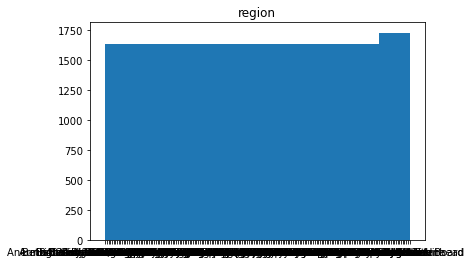

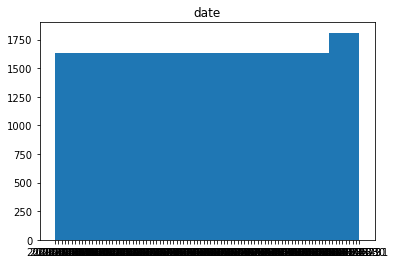

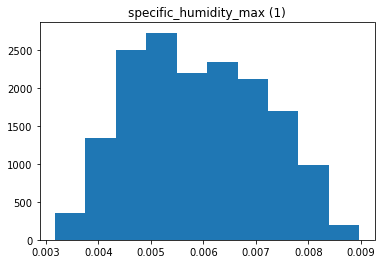

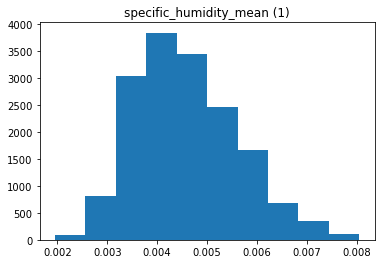

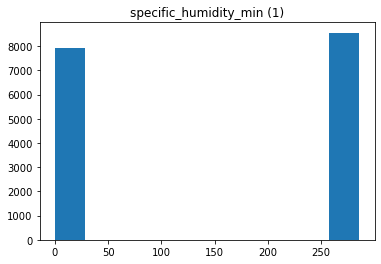

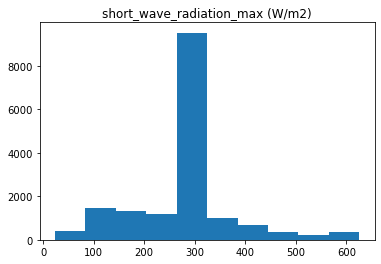

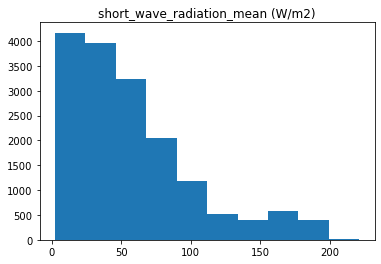

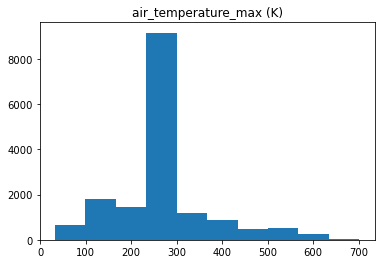

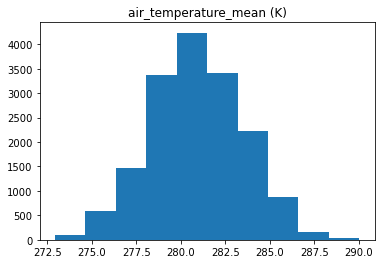

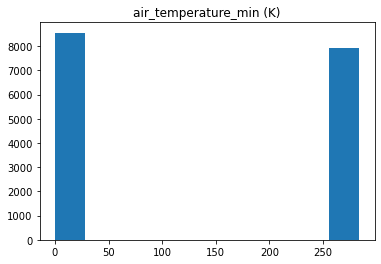

CPU times: user 4.37 s, sys: 423 ms, total: 4.8 s
Wall time: 4.72 s


In [25]:
%%time
for col in dfd:
    plt.hist(dfd[col])
    plt.title(f'{col}')
    plt.show()

## Save large daataframe out to CSV

In [59]:
%%time
df.to_csv('/data/misc/covid-19/regional_data/_UK_daily_met_data_2020jan-mar.csv', index=False)

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 1.04 s


In [69]:
!ls -alh /data/misc/covid-19/regional_data/_UK_daily_met_data_2020jan-mar.csv

-rwxrwxrwx 1 root root 2.0M Apr  5 17:49 /data/misc/covid-19/regional_data/_UK_daily_met_data_2020jan-mar.csv


In [70]:
pd.read_csv('/data/misc/covid-19/regional_data/_UK_daily_met_data_2020jan-mar.csv')

,region,date,specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K)
0,Hampshire,2020-01-01,0.006390,0.005631,0.005040,147.596450,23.381704,281.01580,279.54037,277.95755
1,Hampshire,2020-01-02,0.007195,0.006580,0.006082,97.277590,15.140271,283.15085,281.94280,280.36322
2,Hampshire,2020-01-03,0.007592,0.005721,0.004235,194.037430,31.136189,283.74826,280.91147,277.04803
3,Hampshire,2020-01-04,0.005666,0.005046,0.004283,117.046104,18.044327,280.91030,278.72880,276.05670
4,Hampshire,2020-01-05,0.005917,0.005553,0.005100,139.915510,22.792992,281.66705,280.22424,279.15433
...,...,...,...,...,...,...,...,...,...,...
16466,Warwickshire,2020-03-27,0.004211,0.003734,0.003337,565.088560,165.535190,284.58790,278.38306,273.25650
16467,Warwickshire,2020-03-28,0.004639,0.003956,0.003408,511.124020,132.670270,283.10287,278.83084,275.48960
16468,Warwickshire,2020-03-29,0.003657,0.002885,0.002218,472.583340,124.257965,280.05045,277.27072,275.08755
16469,Warwickshire,2020-03-30,0.005152,0.004088,0.002960,352.203770,83.053750,280.93393,277.59485,273.22070


In [5]:
df1 = pd.DataFrame({'Name': ['a', 'b', 'c'],
                    'num': [1,2,3]})
df2 = pd.DataFrame({'num': [1,2,3], 'Name': ['a', 'b', 'c']})

display(df1)
display(df2)

,Name,num
0,a,1
1,b,2
2,c,3


,num,Name
0,1,a
1,2,b
2,3,c


In [7]:
pd.concat([df1, df2], ignore_index=True)

,Name,num
0,a,1
1,b,2
2,c,3
3,a,1
4,b,2
5,c,3
